In [20]:
from lib.compare import CompareModel
from lib.data import load_info, sample_pairs, aggregate_subjects
from lib.validate import validate, plot_roc
from lib.submit import compare_all
from lib import metrics
from pathlib import Path
import pickle
import mxnet as mx
import numpy as np
from skimage import io
import cv2
from tqdm import tqdm
import typing as t
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import cluster, preprocessing
import optuna
from more_itertools import unzip

In [2]:
data_path = Path('/run/media/andrey/Fast/FairFace/wide_faces_train')
csv_path = Path('data/train_df.csv')
data = load_info(data_path, csv_path)
exists = [idx for idx, cur_path in enumerate(data['img_path']) if cur_path.exists()]
data = data.iloc[np.array(exists)]
val_data_path = Path('/run/media/andrey/Fast/FairFace/data_prep2/train/data')
val_csv_path = Path('data/val_df.csv')
val_data = load_info(val_data_path, val_csv_path)
exists = [idx for idx, cur_path in enumerate(val_data['img_path']) if cur_path.exists()]
val_data = val_data.iloc[np.array(exists)]

In [3]:
from insightface import model_zoo
model_zoo.get_model('arcface_r100_v1')

In [4]:
comparator = CompareModel(ctx=mx.gpu(0))

In [5]:
res = [comparator(cur_p, cur_p) for cur_p in tqdm(val_data['img_path'])]

100%|██████████| 20078/20078 [04:06<00:00, 81.52it/s]


In [6]:
embeddings_dict = comparator.embeddings
embeddings = np.array([embeddings_dict[cur_p] for cur_p in val_data['img_path']])
embeddings_sqr = np.sum(embeddings ** 2, axis=-1, keepdims=True)
norm_embeddings = embeddings / np.sqrt(embeddings_sqr)

cosine_dist_matrix = np.maximum(0, 1 - norm_embeddings.dot(norm_embeddings.T))
euclidean_dist_matrix = np.maximum(0, embeddings_sqr + embeddings_sqr.T - 2 * embeddings.dot(embeddings.T))

num_sample = 10 ** 5
subject_dict = aggregate_subjects(val_data['TEMPLATE_ID'], val_data['SUBJECT_ID'])
sampled_pairs, sampled_labels = unzip(sample_pairs(subject_dict, num_sample))
sampled_pairs = list(sampled_pairs)
sampled_labels = np.array(list(sampled_labels))

In [30]:
NO_LABEL = -1


def calc_closest_k(embs, k: int = 2, batch_size: int = 10 ** 3, use_gpu: bool = True):
    closest_vals = np.empty((embs.shape[0], k), dtype=np.float32)
    closest_idx = np.empty((embs.shape[0], k), dtype=np.int32)
    if use_gpu:
        ctx = mx.gpu(0)
    else:
        ctx = mx.cpu()
    mx_embeddings = mx.nd.array(embs.astype(np.float32), ctx=ctx)
    mx_embeddings = mx_embeddings / mx.nd.sqrt(mx.nd.sum(mx_embeddings ** 2, axis=-1, keepdims=True))
    for bg in tqdm(range(0, embs.shape[0], batch_size)):
        ed = min(embs.shape[0], bg + batch_size)
        cur_embs = mx_embeddings[bg:ed]
        cur_dist = 1 - mx.nd.dot(cur_embs, mx_embeddings.T)
        cur_vals, cur_idx = mx.nd.topk(cur_dist, k=k, axis=-1, ret_typ='both', dtype='int32', is_ascend=True)
        closest_vals[bg:ed] = cur_vals.asnumpy()
        closest_idx[bg:ed] = cur_idx.asnumpy()
    return closest_vals, closest_idx


def label_embeddings(embs, k: int = 3, threshold: float = 0.3, use_gpu: bool = True):
    labels = np.zeros((embs.shape[0],), dtype=np.int32) + NO_LABEL
    cur_label = 0
    closest_vals, closest_idx = calc_closest_k(embs, k=k, use_gpu=use_gpu)
    for cur_idx, (cur_dists, cur_closest) in tqdm(enumerate(zip(closest_vals, closest_idx))):
        if labels[cur_idx] != NO_LABEL:
            continue
        to_label = cur_closest[cur_dists < threshold]
        if np.all(labels[to_label]) != NO_LABEL:
            search_labels = np.unique(labels[to_label])
            more_to_label = [to_label]
            for cur_l in search_labels:
                if cur_l == NO_LABEL:
                    continue
                more_to_label.append(np.where(labels == cur_l)[0])
            to_label = np.concatenate(more_to_label, axis=0)
        labels[to_label] = cur_label
        cur_label += 1
    return labels


def cluster_sklearn(embs, algorithm, dist_matrix=None):
    if dist_matrix is None:
        algorithm.fit(embs)
    else:
        algorithm.fit(dist_matrix)
    return algorithm.labels_


def get_medians(embs, labels, norm_median: bool = False):
    per_label = {}
    for cur_emb, cur_label in zip(embs, labels):
        if cur_label not in per_label:
            per_label[cur_label] = []
        per_label[cur_label].append(cur_emb)
    medias = {}
    for cur_label, cur_embs in per_label.items():
        if cur_label == NO_LABEL:
            continue
        median = np.mean(cur_embs, axis=0)
        if norm_median:
            median = median / np.sqrt(np.sum(median ** 2, axis=-1, keepdims=True))
        medias[cur_label] = median
    ret_medians = np.empty(embs.shape, dtype=np.float32)
    for cur_idx, cur_label in enumerate(labels):
        if cur_label == NO_LABEL:
            ret_medians[cur_idx] = embs[cur_idx]
        else:
            ret_medians[cur_idx] = medias[cur_label]
    return ret_medians


def config_median_comparator(comparator, label_method, all_paths: t.List[Path], metric, norm_median: bool = False, median_alpha: float = 1.0):

#     print('Preparing embeddings')
    res = [comparator(cur_p, cur_p) for cur_p in (all_paths)]
    embeddings_dict = comparator.embeddings
    embeddings = np.array([embeddings_dict[cur_p] for cur_p in all_paths])
    path_idx = {path: idx for idx, path in enumerate(all_paths)}
#     print('Getting medians')
    labels = label_method(embeddings)
    medians = get_medians(embeddings, labels, norm_median)
    # embeddings = preprocessing.normalize(embeddings)
    # medians = preprocessing.normalize(medians)
    
#     print('Done configurating')

    def compare(left_path: Path, right_path: Path):
        left_embedding = embeddings[path_idx[left_path]]
        left_median = medians[path_idx[left_path]]
        right_embedding = embeddings[path_idx[right_path]]
        right_median = medians[path_idx[right_path]]
        left_comp = left_median * median_alpha + left_embedding * (1 - median_alpha)
        right_comp = right_median * median_alpha + right_embedding * (1 - median_alpha)
        return metric(left_comp, right_comp)
    
    return compare


def comp_validate(comparator):
    preds = np.array(list(unzip(compare_all(val_data_path, sampled_pairs, comparator))[2]))
    auc = roc_auc_score(sampled_labels, preds)
    return auc


def optuna_cluster_objective(trial):
    cluster_method = trial.suggest_categorical('cluster_method', ['DBSCAN', 'Agglomerative clustering'])
    cluster_metric = trial.suggest_categorical('cluster_metric', ['cosine', 'euclidean'])
    if cluster_metric == 'cosine':
        eps = trial.suggest_uniform('distance_threshold', 0.1, 2.0)
        dist = cosine_dist_matrix
    else:
        eps = trial.suggest_uniform('distance_threshold', 150, 700)
        dist = euclidean_dist_matrix
    if cluster_method == 'DBSCAN':
        algorithm = cluster.DBSCAN(
            eps=eps,
            min_samples=trial.suggest_int('min_samples', 1, 10),
            metric='precomputed',
            n_jobs=1
        )
    elif cluster_method == 'OPTICS':
        algorithm = cluster.OPTICS(
            min_samples=trial.suggest_int('min_samples', 1, 10),
            max_eps=eps,
            metric='precomputed',
            cluster_method=trial.suggest_categorical('ins_cluster_method', ['xi', 'dbscan']),
            n_jobs=1
        )
    elif cluster_method == 'Agglomerative clustering':
        algorithm = cluster.AgglomerativeClustering(
            n_clusters=None,
            affinity='precomputed',
            memory='/run/media/andrey/Data/cluster_cache/',
            linkage=trial.suggest_categorical('linkage', ['complete', 'average', 'single']),
            distance_threshold=eps
        )
    else:
        algorithm = None
    metric_str = trial.suggest_categorical('metric', ['cosine', 'euclidean'])
    if metric_str == 'cosine':
        metric = metrics.cosine
    else:
        metric = metrics.euclidean
    norm_median = False  # trial.suggest_categorical('norm_median', [False, True])
    median_alpha = trial.suggest_uniform('median_alpha', 0.0, 1.0)
    all_paths = val_data['img_path']
    median_comparator = config_median_comparator(comparator, partial(cluster_sklearn, algorithm=algorithm, dist_matrix=dist), all_paths, metric, norm_median, median_alpha)
    return comp_validate(median_comparator)


def optuna_objective(trial):
    metric_str = trial.suggest_categorical('metric', ['cosine', 'euclidean'])
    if metric_str == 'cosine':
        metric = metrics.cosine
    else:
        metric = metrics.euclidean
    k = trial.suggest_int('k_closest', 1, 1000)
    threshold = trial.suggest_uniform('threshold', 0.1, 1.5)
    norm_median = trial.suggest_categorical('norm_median', [False, True])
    median_alpha = trial.suggest_uniform('median_alpha', 0.0, 1.0)
    all_paths = val_data['img_path']
    median_comparator = config_median_comparator(comparator, partial(label_embeddings, k=k, threshold=threshold), all_paths, metric, norm_median, median_alpha)
    # labels, preds = validate(median_comparator, val_data_path, Path('wide_val.csv'), num_sample=10 ** 5)
    return comp_validate(median_comparator)


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(optuna_cluster_objective, n_trials=1000, n_jobs=-1, timeout=21600)

trial = study.best_trial

print('AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-06-21 14:53:33,366] Finished trial#4 with value: 0.9881707258000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8915353693680899, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6548988415594724}. Best is trial#4 with value: 0.9881707258000001.
[I 2020-06-21 14:53:34,029] Finished trial#1 with value: 0.9778990679999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'euclidean', 'distance_threshold': 688.4711319977976, 'linkage': 'single', 'metric': 'euclidean', 'median_alpha': 0.0872511537956584}. Best is trial#4 with value: 0.9881707258000001.
[I 2020-06-21 14:53:35,186] Finished trial#3 with value: 0.9810626353999999 with parameters: {'cluster_method': 'DBSCAN', 'cluster_metric': 'euclidean', 'distance_threshold': 339.9983872769477, 'min_samples': 2, 'metric': 'cosine', 'median_alpha': 0.3137637685102287}. Best is trial#4 with value: 0.9881707258000001.
[

[I 2020-06-21 14:59:14,658] Finished trial#37 with value: 0.9861161507999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9179956487914406, 'linkage': 'average', 'metric': 'euclidean', 'median_alpha': 0.3373134422424418}. Best is trial#4 with value: 0.9881707258000001.
[I 2020-06-21 14:59:14,751] Finished trial#36 with value: 0.9871895186000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9279714641110125, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.3427600600629396}. Best is trial#4 with value: 0.9881707258000001.
[I 2020-06-21 14:59:19,826] Finished trial#38 with value: 0.9865142346 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9164001578240075, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.31970051659909143}. Best is trial#4 with value: 

[I 2020-06-21 15:05:20,734] Finished trial#72 with value: 0.9853097946 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.108569473320397, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.562164792361254}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:05:23,878] Finished trial#73 with value: 0.9777604544 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.6793714361635282, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.572082799527101}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:05:31,196] Finished trial#74 with value: 0.9837219751999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.7883486385612425, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5645845960571331}. Best is trial#61 with value: 0.9882241866.
[I 2

[I 2020-06-21 15:10:59,644] Finished trial#108 with value: 0.9846114232 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8054401757723789, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.45191736691440954}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:11:03,689] Finished trial#109 with value: 0.9848475686 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8086827236014928, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.48734030748913615}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:11:22,505] Finished trial#110 with value: 0.9780096214 with parameters: {'cluster_method': 'DBSCAN', 'cluster_metric': 'cosine', 'distance_threshold': 1.1629470340951242, 'min_samples': 3, 'metric': 'euclidean', 'median_alpha': 0.4569866034248096}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:11:33,39

[I 2020-06-21 15:15:02,271] Finished trial#134 with value: 0.9865666604 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0063639848407344, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.2983681060363689}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:15:17,989] Finished trial#135 with value: 0.9880939846000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8696422511811499, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.46883758889692284}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:15:18,285] Finished trial#136 with value: 0.9880148474 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.87465581057295, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.46835123891563235}. Best is trial#61 with value: 0.9882241866

[I 2020-06-21 15:19:05,478] Finished trial#160 with value: 0.9875112062 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9098512580760683, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6656463255935361}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:19:05,646] Finished trial#159 with value: 0.9877821751999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9067186531410674, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5084784178018105}. Best is trial#61 with value: 0.9882241866.
[I 2020-06-21 15:19:09,800] Finished trial#161 with value: 0.9877681065999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9034985755525453, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.513352373871383}. Best is trial#61 with value: 0.98822

[I 2020-06-21 15:24:55,720] Finished trial#197 with value: 0.9883158694 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9889663624486925, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4724594192292893}. Best is trial#192 with value: 0.9883588094.
[I 2020-06-21 15:24:58,367] Finished trial#198 with value: 0.9883418544 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9882480120265666, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4723089682095801}. Best is trial#192 with value: 0.9883588094.
[I 2020-06-21 15:24:59,427] Finished trial#199 with value: 0.9881715555999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9954626090391566, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4723684472126765}. Best is trial#192 with value: 0.9883588

[I 2020-06-21 15:29:07,135] Finished trial#224 with value: 0.987915777 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9426898572317158, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4380829499623499}. Best is trial#205 with value: 0.988438048.
[I 2020-06-21 15:29:30,275] Finished trial#225 with value: 0.9868459712000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9373439968062433, 'linkage': 'average', 'metric': 'euclidean', 'median_alpha': 0.4644211113574277}. Best is trial#205 with value: 0.988438048.
[I 2020-06-21 15:29:34,021] Finished trial#226 with value: 0.9880314353999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9369175541548046, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4599665403360107}. Best is trial#205 with value: 0.98843

[I 2020-06-21 15:33:10,450] Finished trial#249 with value: 0.9874269445999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9038239280830889, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.44561930929768995}. Best is trial#205 with value: 0.988438048.
[I 2020-06-21 15:33:14,515] Finished trial#250 with value: 0.9879366356000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9303617517457847, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4442574931493652}. Best is trial#205 with value: 0.988438048.
[I 2020-06-21 15:33:23,958] Finished trial#251 with value: 0.9874986044000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9111219204747849, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.44721637578626566}. Best is trial#205 with valu

[I 2020-06-21 15:39:00,834] Finished trial#281 with value: 0.9823690732 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0177069154874807, 'linkage': 'complete', 'metric': 'cosine', 'median_alpha': 0.5757673321057833}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:39:02,334] Finished trial#282 with value: 0.9780096208000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0106818838099743, 'linkage': 'single', 'metric': 'euclidean', 'median_alpha': 0.5726784712268957}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:39:07,134] Finished trial#283 with value: 0.9814455876 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.017846506461294, 'linkage': 'single', 'metric': 'cosine', 'median_alpha': 0.5595475165450787}. Best is trial#254 with value: 0.9885275358.
[I 202

[I 2020-06-21 15:43:17,602] Finished trial#308 with value: 0.9882050425999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8986842681775575, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6087725374992149}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:43:25,632] Finished trial#309 with value: 0.9880748632 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8987740267298829, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5010490956490253}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:43:28,822] Finished trial#310 with value: 0.9883670160000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9855316737773085, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5005564876950787}. Best is trial#254 with value: 0.9

[I 2020-06-21 15:49:02,507] Finished trial#346 with value: 0.9780096218000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.9458711159343045, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5060796727561874}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:49:27,439] Finished trial#347 with value: 0.988162476 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.874367547290985, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5095896219726049}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:49:31,223] Finished trial#348 with value: 0.987821985 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8858263153979906, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5103563289218382}. Best is trial#254 with value: 0.9885275358

[I 2020-06-21 15:53:10,925] Finished trial#371 with value: 0.9794661792 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.99439435984711, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.03096750977339563}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:53:16,936] Finished trial#372 with value: 0.9867170399999998 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.003493556588813, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6239259776609664}. Best is trial#254 with value: 0.9885275358.
[I 2020-06-21 15:53:20,053] Finished trial#373 with value: 0.9872763713999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0123617240456935, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5351321609122288}. Best is trial#254 with value: 0.988

[I 2020-06-21 15:57:08,470] Finished trial#396 with value: 0.9874369274000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9405491673338348, 'linkage': 'average', 'metric': 'euclidean', 'median_alpha': 0.48873640218651104}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 15:57:18,550] Finished trial#397 with value: 0.978009622 with parameters: {'cluster_method': 'DBSCAN', 'cluster_metric': 'cosine', 'distance_threshold': 0.9596618429598002, 'min_samples': 6, 'metric': 'euclidean', 'median_alpha': 0.48876657636551335}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 15:57:24,271] Finished trial#399 with value: 0.9753594482 with parameters: {'cluster_method': 'DBSCAN', 'cluster_metric': 'euclidean', 'distance_threshold': 162.93810693015246, 'min_samples': 6, 'metric': 'euclidean', 'median_alpha': 0.47989785286938696}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 15:57:25,433] Finished 

[I 2020-06-21 16:03:40,542] Finished trial#431 with value: 0.9874283215999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.884113475305653, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4648648929559978}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:03:44,149] Finished trial#432 with value: 0.9877957064 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8843530068302061, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5098028483914085}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:03:51,941] Finished trial#433 with value: 0.9879917154 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8900754075403738, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.4636632389987013}. Best is trial#376 with value: 0.98862764

[I 2020-06-21 16:09:11,724] Finished trial#461 with value: 0.9880383560000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9725359210822295, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5102087644535239}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:09:16,195] Finished trial#462 with value: 0.988497941 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9825151905107513, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5040932116223252}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:09:21,785] Finished trial#464 with value: 0.9880922116 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.8987119002683268, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5068791811346042}. Best is trial#376 with value: 0.98862764

[I 2020-06-21 16:15:32,447] Finished trial#497 with value: 0.988384031 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.988539771443466, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5168339603014217}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:15:37,940] Finished trial#498 with value: 0.9883641904000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9922267157140284, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5153594250208093}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:15:38,773] Finished trial#499 with value: 0.9884939052 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.98659487294486, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5171430085872374}. Best is trial#376 with value: 0.9886276498.

[I 2020-06-21 16:21:24,579] Finished trial#527 with value: 0.9880538526000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9327584425518672, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5467668076678533}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:21:26,792] Finished trial#528 with value: 0.9881048779999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9334661723938241, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5472406501015515}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:21:30,179] Finished trial#529 with value: 0.9882868038 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9352415838155657, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5344989391582939}. Best is trial#376 with value: 0.9

[I 2020-06-21 16:27:07,666] Finished trial#561 with value: 0.9884315947999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.981949815500136, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.594828808668862}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:27:19,781] Finished trial#562 with value: 0.9720806134 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'euclidean', 'distance_threshold': 501.81122369239534, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5915812638832194}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:28:00,018] Finished trial#563 with value: 0.975778136 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'euclidean', 'distance_threshold': 184.1349253030755, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5117882625263686}. Best is trial#376 with value: 0.98862

[I 2020-06-21 16:33:08,120] Finished trial#593 with value: 0.987639581 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9052828430237567, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.48726117343150604}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:33:09,514] Finished trial#594 with value: 0.9880783826 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9712271577685296, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5358908185504304}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:33:14,625] Finished trial#596 with value: 0.9883756846 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9905669864872819, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5362721849771787}. Best is trial#376 with value: 0.9886276498.
[

[I 2020-06-21 16:39:05,133] Finished trial#629 with value: 0.9821971044000001 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.7609193704079338, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6706175242525325}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:39:06,845] Finished trial#630 with value: 0.9821489581999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.7460947179275101, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5174667813137347}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:39:18,478] Finished trial#631 with value: 0.9837151024 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.795576871924643, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6418108644882375}. Best is trial#376 with value: 0.98

[I 2020-06-21 16:45:05,776] Finished trial#664 with value: 0.9865344994 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.066932615452709, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5039045463964731}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:45:39,379] Finished trial#665 with value: 0.9860818804 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0772707610571037, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5056201967299276}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:45:43,247] Finished trial#666 with value: 0.9870189511999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0479645190126237, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5030960887890429}. Best is trial#376 with value: 0.98862764

[I 2020-06-21 16:49:17,449] Finished trial#689 with value: 0.9873439499999999 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.0069298457825426, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5506262467103203}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:49:21,095] Finished trial#690 with value: 0.9881127128 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 0.9892188938331407, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.6283950324103404}. Best is trial#376 with value: 0.9886276498.
[I 2020-06-21 16:49:42,326] Finished trial#692 with value: 0.9780096212 with parameters: {'cluster_method': 'Agglomerative clustering', 'cluster_metric': 'cosine', 'distance_threshold': 1.5330727236758201, 'linkage': 'complete', 'metric': 'euclidean', 'median_alpha': 0.5438684518855956}. Best is trial#376 with value: 0.9886276

In [31]:
# val_data_path = Path('./wide_faces_train')
# val_csv_path = Path('/content/drive/My Drive/colab/fair_face/val_df.csv')
# val_data = load_info(data_path, val_csv_path)

all_paths = val_data['img_path']

metric = metrics.cosine
k = 10
threshold = 0.3
norm_median = False
median_alpha = 1.0
median_comparator = config_median_comparator(comparator, partial(label_embeddings, k=k, threshold=threshold), all_paths, metric, norm_median, median_alpha)
# median_comparator2 = config_median_comparator(comparator, partial(label_embeddings, k=k, threshold=threshold), all_paths, metric, norm_median, median_alpha)

100%|██████████| 21/21 [00:00<00:00, 22.66it/s]
20078it [00:00, 69804.59it/s]


In [32]:
algorithm = cluster.AgglomerativeClustering(
            n_clusters=None,
            affinity='cosine',
            memory='/run/media/andrey/Data/cluster_cache/',
            linkage='complete',
            distance_threshold=0.9291274601315189
        )
norm_median = False
median_alpha = 0.5040577648719912
metric = metrics.euclidean
cluster_comparator_eu = config_median_comparator(comparator, partial(cluster_sklearn, algorithm=algorithm), all_paths, metric, norm_median, median_alpha)

metric = metrics.cosine
cluster_comparator_co = config_median_comparator(comparator, partial(cluster_sklearn, algorithm=algorithm), all_paths, metric, norm_median, median_alpha)

metric = lambda a, b: np.sum(a * b, -1)
cluster_comparator_my = config_median_comparator(comparator, partial(cluster_sklearn, algorithm=algorithm), all_paths, metric, norm_median, median_alpha)


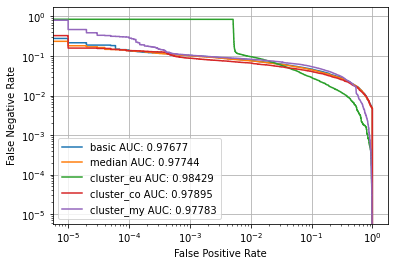

In [33]:
val = partial(validate, data_dir=val_data_path, validation_csv=val_csv_path, num_sample=200000)
plot_roc([val(comparator), val(median_comparator), val(cluster_comparator_eu), val(cluster_comparator_co), val(cluster_comparator_my)], 
         ['basic', 'median', 'cluster_eu', 'cluster_co', 'cluster_my'])

In [7]:
val_data.to_csv('data/wide_val.csv')
val_data.head()

,Unnamed: 0,TEMPLATE_ID,SUBJECT_ID,AGE,SKIN_COLOUR,GENDER,HEAD_POSE,SOURCE,GLASSES,BOUNDING_BOX_SIZE,img_path
0,40330,146692,30127,1,0,1,1,0,0,1,/run/media/andrey/Fast/FairFace/data_prep2/tra...
1,41447,146693,30127,1,0,1,1,0,0,1,/run/media/andrey/Fast/FairFace/data_prep2/tra...
2,59029,146691,30127,1,0,1,1,0,0,1,/run/media/andrey/Fast/FairFace/data_prep2/tra...
3,80019,146690,30127,1,0,1,1,0,0,1,/run/media/andrey/Fast/FairFace/data_prep2/tra...
4,4,71048,14005,0,0,1,0,0,0,1,/run/media/andrey/Fast/FairFace/data_prep2/tra...
